### Importing relevant libraries

In [1]:
from PIL import Image 
import numpy as np
import os
from os import listdir
from PIL import Image 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import regularizers
import numpy as np
import warnings
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

### Loading labels

In [2]:
df= pd.read_csv('../input/arabic-hwr-ai-pro-intake1/train.csv')
df

,id,label
0,0,24
1,1,2
2,2,17
3,3,14
4,4,19
...,...,...
13435,13435,5
13436,13436,26
13437,13437,2
13438,13438,24


In [3]:
labels= df['label']

In [4]:
labels.shape

(13440,)

### Loading images

In [5]:
train_path="../input/arabic-hwr-ai-pro-intake1/train/"
test_path="../input/arabic-hwr-ai-pro-intake1/test/"

In [6]:
def loadImages(path):
    # returns array of images
    
    imagesList = listdir(path)
    imagesList.sort()
    image_df = []
    for image in imagesList:
        img = Image.open(path + image).convert('L')
        img=img.resize((32,32))
        img=np.asarray(img)
        img=img.reshape((32,32,1))
        img=img/255
        image_df.append(img)
    
    return np.array(image_df)

In [7]:
train_data = loadImages(train_path)
test_data= loadImages(test_path)

In [8]:
train_data.shape

(13440, 32, 32, 1)

In [9]:
test_data.shape

(3360, 32, 32, 1)

### Visualizing some images

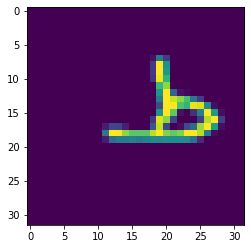

In [10]:
plt.imshow(train_data[3000])

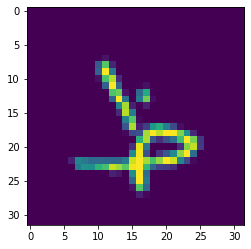

In [11]:
plt.imshow(train_data[2])

### Shuffling images

In [12]:
indices = np.arange(train_data.shape[0])
np.random.shuffle(indices)
shuffled_images = train_data[indices]
shuffled_labels = labels[indices]


### Dividing data into train/validation/test

In [13]:
validation_samples= int(0.1*train_data.shape[0])    #nearly 10%
test_samples = int(0.1*train_data.shape[0])        #nearly 10%    
train_samples = train_data.shape[0]-(validation_samples+test_samples)      #nearly 80%


In [14]:
validation_images= shuffled_images[:validation_samples]
validation_labels= shuffled_labels[:validation_samples]

test_images = shuffled_images[validation_samples:validation_samples+test_samples]
test_labels= shuffled_labels[validation_samples:validation_samples+test_samples]


train_images = shuffled_images[validation_samples+test_samples:]
train_labels = shuffled_labels[validation_samples+test_samples:]



In [15]:
train_images.shape

(10752, 32, 32, 1)

In [16]:
validation_images.shape

(1344, 32, 32, 1)

In [17]:
test_images.shape

(1344, 32, 32, 1)

### Model outline

In [18]:
model = tf.keras.Sequential([
    
    

    tf.keras.layers.Conv2D(128,3,activation='relu',input_shape=(32,32,1)),
    tf.keras.layers.Conv2D(128,3,activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),


        
    tf.keras.layers.Conv2D(64,3,activation='relu'),
    tf.keras.layers.Conv2D(64,3,activation='relu'),


    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024,'relu'),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(1024,'relu'),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(29)
    
    
])                                

2021-11-05 16:56:26.524626: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 16:56:26.627678: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 16:56:26.628768: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 16:56:26.632430: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

### Model architecture

In [19]:
model.summary(line_length=75)

Model: "sequential"
___________________________________________________________________________
Layer (type)                     Output Shape                  Param #     
conv2d (Conv2D)                  (None, 30, 30, 128)           1280        
___________________________________________________________________________
conv2d_1 (Conv2D)                (None, 28, 28, 128)           147584      
___________________________________________________________________________
max_pooling2d (MaxPooling2D)     (None, 14, 14, 128)           0           
___________________________________________________________________________
conv2d_2 (Conv2D)                (None, 12, 12, 64)            73792       
___________________________________________________________________________
conv2d_3 (Conv2D)                (None, 10, 10, 64)            36928       
___________________________________________________________________________
global_average_pooling2d (Global (None, 64)                    0    

### Compiling our model

In [20]:
loss_fn= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [21]:
model.compile(optimizer='adam',loss=loss_fn,metrics=['accuracy'])

### Defining early stopping technique

In [22]:
early_stopping=tf.keras.callbacks.EarlyStopping(
monitor='val_loss',
mode='auto',
min_delta=0,
patience=10,
verbose=0,
restore_best_weights=True)

### Fitting our model

In [23]:
model.fit(
    train_images,
    train_labels,
    epochs=100,
    batch_size=128,
    callbacks=[early_stopping],
    validation_data= (validation_images,validation_labels),
    verbose=2
)

2021-11-05 16:56:29.980018: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2021-11-05 16:56:31.304242: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


84/84 - 8s - loss: 3.3441 - accuracy: 0.0377 - val_loss: 3.2800 - val_accuracy: 0.0342
Epoch 2/100
84/84 - 1s - loss: 3.1121 - accuracy: 0.0761 - val_loss: 2.8100 - val_accuracy: 0.1057
Epoch 3/100
84/84 - 1s - loss: 2.7588 - accuracy: 0.1266 - val_loss: 2.3135 - val_accuracy: 0.2493
Epoch 4/100
84/84 - 1s - loss: 2.2215 - accuracy: 0.2425 - val_loss: 1.7932 - val_accuracy: 0.3445
Epoch 5/100
84/84 - 1s - loss: 1.8355 - accuracy: 0.3398 - val_loss: 1.3979 - val_accuracy: 0.4970
Epoch 6/100
84/84 - 1s - loss: 1.5154 - accuracy: 0.4288 - val_loss: 1.2435 - val_accuracy: 0.5379
Epoch 7/100
84/84 - 1s - loss: 1.2950 - accuracy: 0.5034 - val_loss: 1.0914 - val_accuracy: 0.6138
Epoch 8/100
84/84 - 1s - loss: 1.1213 - accuracy: 0.5685 - val_loss: 0.8141 - val_accuracy: 0.7009
Epoch 9/100
84/84 - 1s - loss: 0.9684 - accuracy: 0.6308 - val_loss: 0.6496 - val_accuracy: 0.8013
Epoch 10/100
84/84 - 1s - loss: 0.8256 - accuracy: 0.6923 - val_loss: 0.5329 - val_accuracy: 0.8333
Epoch 11/100
84/84 - 

In [24]:
model.evaluate(test_images,test_labels)

42/42 [==============================] - 0s 3ms/step - loss: 0.1307 - accuracy: 0.9643


[0.13068664073944092, 0.9642857313156128]

### Retraining the model with larger batch size

In [25]:
# model.fit(
#     train_images,
#     train_labels,
#     epochs=10,
#     batch_size=512,
#     callbacks=[early_stopping],
#     validation_data= (validation_images,validation_labels),
#     verbose=2
# )

In [26]:
# model.evaluate(test_images,test_labels)

### Extracting the most important features

In [27]:
layer_output=model.get_layer(index=6).output

In [28]:
intermediate_model=tf.keras.models.Model(inputs=model.input,outputs=layer_output)

In [29]:
new_train_features= intermediate_model.predict(train_data)
new_test_features= intermediate_model.predict(test_data)

In [30]:
new_train_features.shape

(13440, 64)

In [31]:
new_test_features.shape

(3360, 64)

In [32]:
X_train, X_validation,y_train,y_validation = train_test_split(new_train_features,labels, test_size=0.1, random_state=42) 
# y_train, y_validation = train_test_split(labels, test_size=0.1, random_state=42) 


In [33]:
X_train.shape

(12096, 64)

In [34]:
y_train.shape

(12096,)

In [35]:
X_validation.shape

(1344, 64)

In [36]:
y_validation.shape

(1344,)

### Catboost Model

In [37]:
cb = CatBoostClassifier(
    
#                             border_count=100,
    
                            iterations=1000,
    
#                             learning_rate=0.08,

#                               depth=6 ,

#                            l2_leaf_reg=5,
    
#                            bagging_temperature=0.9,
    
    
                         loss_function= 'MultiClass',

                         eval_metric='Accuracy',
                              
                          verbose=True,
                          
                          task_type='CPU',
    
                            random_state=42,
    

    
                
    
    
    
)


cb.fit(X_train,y_train,
          eval_set= [(X_validation, y_validation)],
          
        
          
          )

Learning rate set to 0.113496
0:	learn: 0.5520007	test: 0.5572917	best: 0.5572917 (0)	total: 436ms	remaining: 7m 15s
1:	learn: 0.7102348	test: 0.7358631	best: 0.7358631 (1)	total: 812ms	remaining: 6m 45s
2:	learn: 0.7730655	test: 0.7924107	best: 0.7924107 (2)	total: 1.2s	remaining: 6m 40s
3:	learn: 0.8138228	test: 0.8377976	best: 0.8377976 (3)	total: 1.58s	remaining: 6m 34s
4:	learn: 0.8364749	test: 0.8578869	best: 0.8578869 (4)	total: 1.96s	remaining: 6m 30s
5:	learn: 0.8475529	test: 0.8675595	best: 0.8675595 (5)	total: 2.33s	remaining: 6m 26s
6:	learn: 0.8606978	test: 0.8779762	best: 0.8779762 (6)	total: 2.71s	remaining: 6m 23s
7:	learn: 0.8799603	test: 0.8906250	best: 0.8906250 (7)	total: 3.08s	remaining: 6m 21s
8:	learn: 0.8925265	test: 0.9040179	best: 0.9040179 (8)	total: 3.45s	remaining: 6m 20s
9:	learn: 0.9002149	test: 0.9114583	best: 0.9114583 (9)	total: 3.82s	remaining: 6m 18s
10:	learn: 0.9063327	test: 0.9174107	best: 0.9174107 (10)	total: 4.19s	remaining: 6m 17s
11:	learn: 0

In [38]:
cb.get_best_score()

{'learn': {'Accuracy': 1.0, 'MultiClass': 0.0064853672818828275},
 'validation': {'Accuracy': 0.9880952380952381,
  'MultiClass': 0.0522375502009346}}

### Generating predictions

In [39]:
predictions= cb.predict(new_test_features)

In [40]:
predictions

array([[26],
       [10],
       [ 1],
       ...,
       [ 4],
       [11],
       [20]])

In [41]:
predictions.shape

(3360, 1)

In [42]:
test_df= pd.read_csv('../input/arabic-hwr-ai-pro-intake1/test.csv')

In [43]:
test_df

,id
0,0
1,1
2,2
3,3
4,4
...,...
3355,3355
3356,3356
3357,3357
3358,3358


In [44]:
preds= pd.DataFrame()
preds['id']= test_df['id']
preds['label']= predictions

In [45]:
preds

,id,label
0,0,26
1,1,10
2,2,1
3,3,10
4,4,15
...,...,...
3355,3355,16
3356,3356,6
3357,3357,4
3358,3358,11


### Exporting to csv

In [46]:
preds.to_csv('final_submission.csv',index=False)